In [ ]:
# This notebook will generate additional random testing data for further training of the algorithm

'''
parameters to care about:
    
    background: grey/white
    grid: yes/no
    number of displayed features (1-4)
    shapes used for features
    color used for features
    title/subtitle
    legend (yes/no) / legend_has_title (yes/no)
    axis text
    rotation
    pollution
'''

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as tra
import io
import random
from PIL import Image
from random_word import Wordnik

In [68]:
def random_word_list(length):
    result = []
    for i in range(length):
        result.append(Wordnik().get_random_word(minCorpusCount=99999))
    return result

def list_to_string(lst):
    return ' '.join(lst)

list_to_string(Wordnik().get_random_words(includePartOfSpeech="noun,verb", minCorpusCount=99999, limit=4))

'mistress example evaluation managers'

(844, 419)
(847, 419)


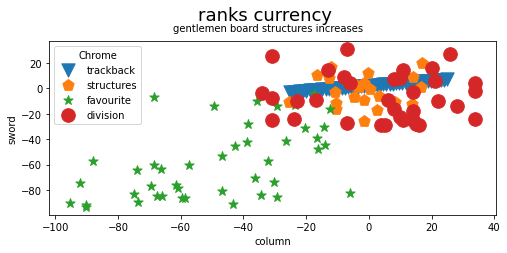

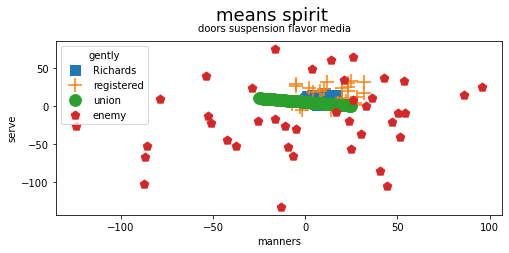

In [111]:


def draw_random_graph(number_of_graphs):
    for graphs_created in range(number_of_graphs):
        markers = [".", "o", "v", "^", "s", "p", "*", "d", "X", "+", ">"]
        random.shuffle(markers)

        legend_length = random.randint(1,4)
        legend = random_word_list(legend_length)


        data_1 = np.random.randn(random.randint(20,50),2)*random.randint(-50,50)
        data_2 = np.random.randint(random.randint(-50,0), random.randint(1,100), size=(random.randint(20,50),2))
        data_3 = np.random.rand(random.randint(20,50),2)*random.randint(-100,100)
        x = random.randint(-10,10) * np.linspace(-5.0, 5.0, 50)
        y = random.randint(1,10) + np.linspace(-5.0, 5.0, 50)
        data_4 = np.stack((x,y), axis=1)

        all_data = [data_1, data_2, data_3, data_4]
        random.shuffle(all_data)

        fig, ax = plt.subplots()

        plt.suptitle(list_to_string(Wordnik().get_random_words(includePartOfSpeech="noun,verb", minCorpusCount=99999, limit=2)), y=1.03, x=0.5, fontsize=18)
        plt.title(list_to_string(Wordnik().get_random_words(includePartOfSpeech="noun,verb", minCorpusCount=99999, limit=4)), y=1.02, x=0.49, fontsize=10)
        plt.ylabel(Wordnik().get_random_word(includePartOfSpeech="noun,verb", minCorpusCount=99999), fontsize=10)
        plt.xlabel(Wordnik().get_random_word(includePartOfSpeech="noun,verb", minCorpusCount=99999), fontsize=10)
        plt.grid(random.choice([True, False]))

        fig.set_size_inches(8, 3.2)

        for i in range(legend_length):
            ax.scatter(all_data[i][:,0], all_data[i][:,1], marker = markers[i], s=random.randint(80, 200),  label = legend[i])

        if (random.choice([True, True, True, True, True, True, True, True, True, True, True, True, False])):
            legend = ax.legend(loc=0, title= random.choice([Wordnik().get_random_word(includePartOfSpeech="noun,verb", minCorpusCount=99999), False]))
            legend.get_frame()

        buffer = io.BytesIO()
        plt.savefig(buffer, format='jpg', dpi=120, bbox_inches="tight")
        buffer.seek(0)


        white = (255,255,255)
        new_image = Image.new("RGB", (1024,512), white)

        plot_img =  Image.open(buffer)
        print(plot_img.size)

        plot_img = plot_img.resize([random.randint(830,845),random.randint(410,430)])

        rotated_img = plot_img.rotate(random.randint(-4,4), expand = 1, fillcolor = white)

        pollution_1 = Image.open("pollution_1.png")
        pollution_2 = Image.open("pollution_2.png")
        pollution_3 = Image.open("pollution_3.png")
        pollution_4 = Image.open("pollution_4.png")

        pollution = [pollution_1, pollution_2, pollution_3, pollution_4, pollution_1, pollution_2, pollution_3, pollution_4]

        new_image.paste(rotated_img, (60,20))

        for i in range(random.randint(1,8)):
            image = pollution[i].resize((random.randint(80,120),random.randint(100,200)))
            new_image.paste(image, (random.randint(10,1000), random.randint(10,500)), image)

        new_image.save("generated_graphs/graph" + str(graphs_created) + ".png")


draw_random_graph(2)


# TODO: axes should be rotated randomly



(836, 419)
